In [230]:
import os
import sys
import csv

import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict

%matplotlib inline

In [249]:
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson
from scipy.stats import nbinom

In [232]:
# rand_counts_file = 'data/random_sig_counts.txt'
rand_counts_file = 'data/gene_random_sig_counts.txt'

In [233]:
def empirical_p(li, v):
    return len([i for i in li if i>= v])/float(len(li))

In [234]:
reader = csv.reader(open(rand_counts_file), delimiter='\t')
header = next(reader)

sigcounts = defaultdict(int)
sigcs = list()

for sample_id, nsnps, sigcount in reader:
    sigcounts[sigcount] += 1
    sigcs.append(int(sigcount))

sigcounts, len(sigcs)

(defaultdict(int,
             {'3': 13,
              '4': 6,
              '5': 7,
              '9': 2,
              '1': 25,
              '0': 22,
              '2': 18,
              '6': 2,
              '7': 3,
              '11': 1,
              '8': 1}),
 100)

## Empirical P-value

In [244]:
# For comparison, here are what the "empirical p-values" are
empirical_p(sigcs, 1), empirical_p(sigcs, 4), empirical_p(sigcs, 10)

(0.78, 0.22, 0.01)

## Fitted P-values

### Poisson

[1.62731811]


Power_divergenceResult(statistic=10637.614964778353, pvalue=0.0)

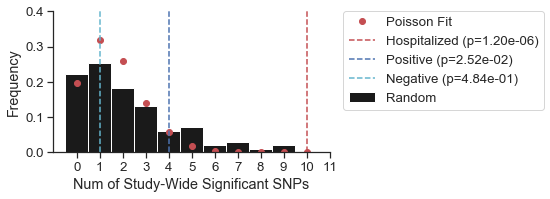

In [247]:
sns.set(style='ticks', font_scale=1.2)
plt.figure(figsize=(8,3))

# the bins should be of integer width, because poisson is an integer distribution
bins = np.arange(11) - 0.5
entries, bin_edges, patches = plt.hist(sigcs, bins=bins, density=True, label='Random', color='k')

# calculate bin centres
bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])


def fit_function(k, lamb):
    '''poisson function, parameter lamb is the fit parameter'''
    return poisson.pmf(k, lamb)


# fit with curve_fit
parameters, cov_matrix = curve_fit(fit_function, bin_middles, entries)
print(parameters)

# plot poisson-deviation with fitted parameter
x_plot = np.arange(0, 11)


plt.plot(
    x_plot,
    fit_function(x_plot, *parameters),
    marker='o', linestyle='',
    color='r',
    label='Poisson Fit',
)

plt.plot([10, 10], [0, 1], 'r--', label='Hospitalized (p=%.2e)' % (1-poisson.cdf(10, parameters[0])))
plt.plot([4, 4], [0, 1], 'b--', label='Positive (p=%.2e)' % (1-poisson.cdf(4, parameters[0])))
plt.plot([1, 1], [0, 1], 'c--', label='Negative (p=%.2e)' % (1-poisson.cdf(1, parameters[0])))

plt.ylim(0,0.4)
plt.xticks(range(0,12), range(0,12))

plt.xlabel('Num of Study-Wide Significant SNPs')
plt.ylabel('Frequency')


#plt.legend(['Hospitalized', 'Negative', 'Positive', 'Random'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
sns.despine()

plt.tight_layout()
plt.savefig('figures/ukbb_empirical_hits_analysis.pdf')


stats.chisquare(
    [sigcounts[c] for c in sorted(sigcounts)], 
    len(sigcs)*fit_function(list(map(int,sorted(sigcounts))), *(parameters))
)

### Negative Binomial

[2.09446944 0.49437291]


Power_divergenceResult(statistic=9.566351406452439, pvalue=0.47932553335008654)

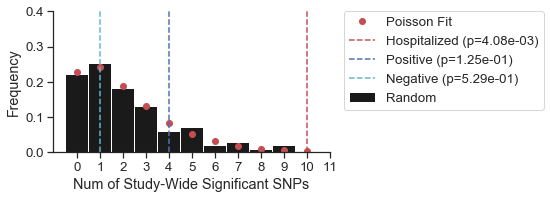

In [284]:
sns.set(style='ticks', font_scale=1.2)
plt.figure(figsize=(8,3))

# the bins should be of integer width, because poisson is an integer distribution
bins = np.arange(11) - 0.5
entries, bin_edges, patches = plt.hist(sigcs, bins=bins, density=True, label='Random', color='k')

# calculate bin centres
bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])


n = 3
def fit_function(k, n, p):
    '''poisson function, parameter lamb is the fit parameter'''
    return nbinom.pmf(k, n, p)


# fit with curve_fit
parameters, cov_matrix = curve_fit(fit_function, bin_middles, entries, p0=[2, 0.01])
print(parameters)

# plot poisson-deviation with fitted parameter
x_plot = np.arange(0, 11)


plt.plot(
    x_plot,
    fit_function(x_plot, *parameters),
    marker='o', linestyle='',
    color='r',
    label='Poisson Fit',
)

plt.plot([10, 10], [0, 1], 'r--', label='Hospitalized (p=%.2e)' % (1-nbinom.cdf(10, parameters[0], parameters[1])))
plt.plot([4, 4], [0, 1], 'b--', label='Positive (p=%.2e)' % (1-nbinom.cdf(4, parameters[0], parameters[1])))
plt.plot([1, 1], [0, 1], 'c--', label='Negative (p=%.2e)' % (1-nbinom.cdf(1, parameters[0], parameters[1])))

plt.ylim(0,0.4)
plt.xticks(range(0,12), range(0,12))

plt.xlabel('Num of Study-Wide Significant SNPs')
plt.ylabel('Frequency')


#plt.legend(['Hospitalized', 'Negative', 'Positive', 'Random'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
sns.despine()

plt.tight_layout()
plt.savefig('figures/ukbb_empirical_hits_analysis.pdf')

stats.chisquare(
    [sigcounts[c] for c in sorted(sigcounts)], 
    len(sigcs)*fit_function(list(map(int,sorted(sigcounts))), *(parameters))
)